<a href="https://colab.research.google.com/github/swathianil/NMA_deeplearning/blob/main/Copy_of_load_hcp_task_with_behaviour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load HCP parcellated task data
## (version with Behavioural Data)

The HCP dataset comprises task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In order to use this dataset, please electronically sign the HCP data use terms at [ConnectomeDB](https://db.humanconnectome.org). Instructions for this are on pp. 24-25 of the [HCP Reference Manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

In this notebook, NMA provides code for downloading the data and doing some basic visualisation and processing.

In [1]:
# @title Install dependencies
!pip install nilearn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 42.6 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [4]:
# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 100

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
RUNS   = ['LR','RL']
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'
# TIP: look inside the data folders for more fine-graned conditions

EXPERIMENTS = {
    'MOTOR'      : {'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss','win']},
    'LANGUAGE'   : {'cond':['math','story']},
    'RELATIONAL' : {'cond':['match','relation']},
    'SOCIAL'     : {'cond':['ment','rnd']}
}

EXP_subset = { 'GAMBLING'   : {'cond':['loss','win']}}  # Only relevant data

> For a detailed description of the tasks have a look pages 45-54 of the [HCP reference manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

# Downloading data

The task data are shared in different files, but they will unpack into the same directory structure.


In [5]:
# @title Download data file
import os, requests

fname = "hcp_task.tgz"
url = "https://osf.io/2y3fw/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [6]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp_task"

# importing the "tarfile" module
import tarfile

# open file
with tarfile.open(fname) as tfile:
  # extracting file
  tfile.extractall('.')

subjects = np.loadtxt(os.path.join(HCP_DIR, 'subjects_list.txt'), dtype='str')

## Understanding the folder organisation

The data folder has the following organisation:

- hcp
  - regions.npy (information on the brain parcellation)
  - subjects_list.txt (list of subject IDs)
  - subjects (main data folder)
    - [subjectID] (subject-specific subfolder)
      - EXPERIMENT (one folder per experiment)
        - RUN (one folder per run)
          - data.npy (the parcellated time series data)
          - EVs (EVs folder)
            - [ev1.txt] (one file per condition)
            - [ev2.txt]
            - Stats.txt (behavioural data [where available] - averaged per run)
            - Sync.txt (ignore this file)



## Loading region information

Downloading this dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).



In [7]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

# Help functions

We provide two helper functions: one for loading the time series from a single suject and a single run, and one for loading an EV file for each task.

An EV file (EV:Explanatory Variable) describes the task experiment in terms of stimulus onset, duration, and amplitude. These can be used to model the task time series data.

In [46]:
ts = np.load("/content/hcp_task/subjects/100307/GAMBLING/tfMRI_GAMBLING_LR/data.npy")

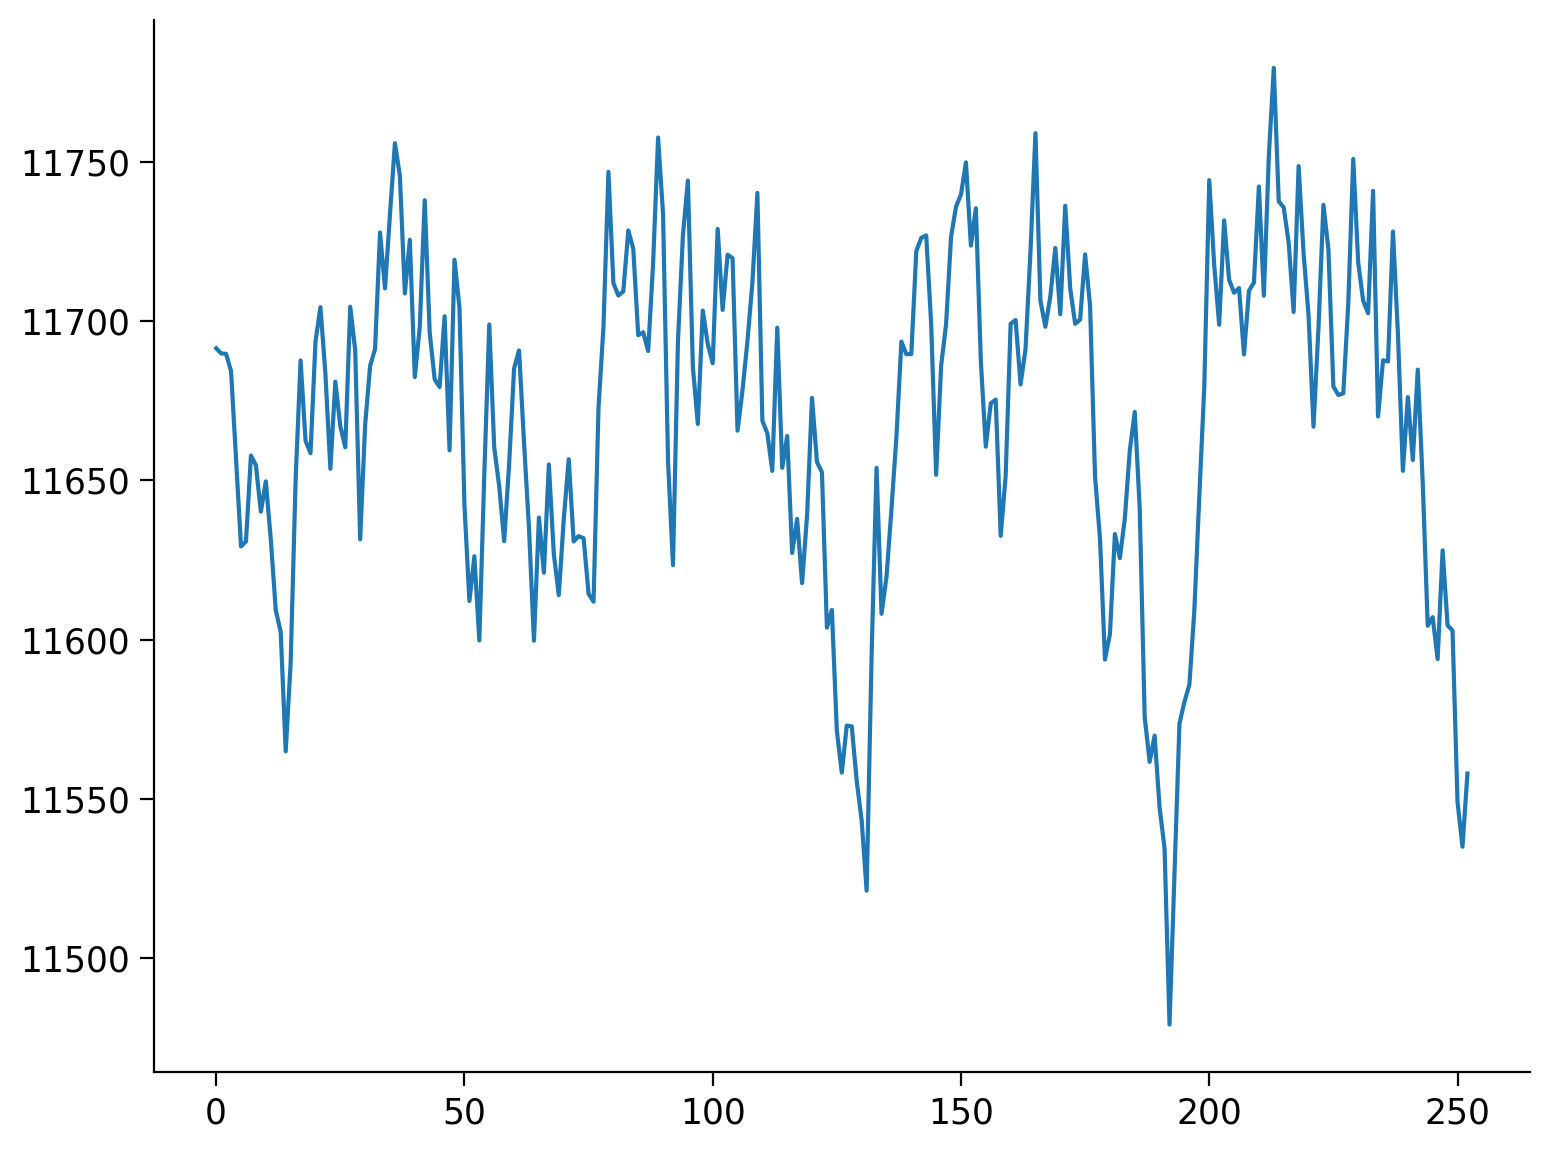

In [9]:
plt.plot(ts[0])#[-1] #- ts[0][0]

In [114]:
def load_single_timeseries(subject, experiment, run, hemi, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (str):      subject ID to load
    experiment (str):   Name of experiment
    run (int):          (0 or 1)
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  N_PARCELS = 360
  bold_run  = RUNS[run]
  print(bold_run)
  bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
  print(bold_path)
  bold_file = "data.npy"
  ts_all = np.load(f"{bold_path}/{bold_file}")

  if hemi == 'right':
    ts = ts_all[0:int(N_PARCELS/2)]
  else:
    ts = ts_all[int(N_PARCELS/2):]
  if remove_mean: # normalise or not
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (str): subject ID to load
    experiment (str) : Name of experiment
    run (int): 0 or 1

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []
  task_key = f'tfMRI_{experiment}_{RUNS[run]}'
  for cond in EXPERIMENTS[experiment]['cond']: # win, loss
    ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames_list.append(frames)

  return frames_list

# Example run

Let's load the timeseries data for the MOTOR experiment from a single subject and a single run

In [117]:
my_exp = 'GAMBLING'
my_subj = subjects[1]
my_run = 1
my_hemi = 'left'


# Load data from one hemisphere and normalise by subtracting mean
data = load_single_timeseries(subject=my_subj,
                              experiment=my_exp,
                              run=my_run,
                              hemi='right',
                              remove_mean=True)

ts = np.load(f"/content/hcp_task/subjects/{subjects[1]}/GAMBLING/tfMRI_GAMBLING_RL/data.npy")
#(data==ts[:180])


RL
./hcp_task/subjects/100408/GAMBLING/tfMRI_GAMBLING_RL


In [111]:
ts[180:].shape
#data.shape

(180, 253)

As you can see the time series data contains 253 time points in 360 regions of interest (ROIs).



Now in order to understand how to model these data, we need to relate the time series to the experimental manipulation. This is described by the EV files. Let us load the EVs for this experiment.

In [118]:
evs = load_evs(subject=my_subj, experiment=my_exp, run=my_run)

In [119]:
loss_ev = np.loadtxt('/content/hcp_task/subjects/100307/GAMBLING/tfMRI_GAMBLING_LR/EVs/loss_event.txt',unpack=True)[0]
win_ev = np.loadtxt('/content/hcp_task/subjects/100307/GAMBLING/tfMRI_GAMBLING_LR/EVs/win_event.txt',unpack=True)[0]
neut_ev = np.loadtxt('/content/hcp_task/subjects/100307/GAMBLING/tfMRI_GAMBLING_LR/EVs/neut_event.txt',unpack=True)[0]

In [120]:
evs

[[array([ 72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
          85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
          98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110]),
  array([133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
         146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
         159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171])],
 [array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
         28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
         45, 46, 47, 48, 49]),
  array([193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
         206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218,
         219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231])]]

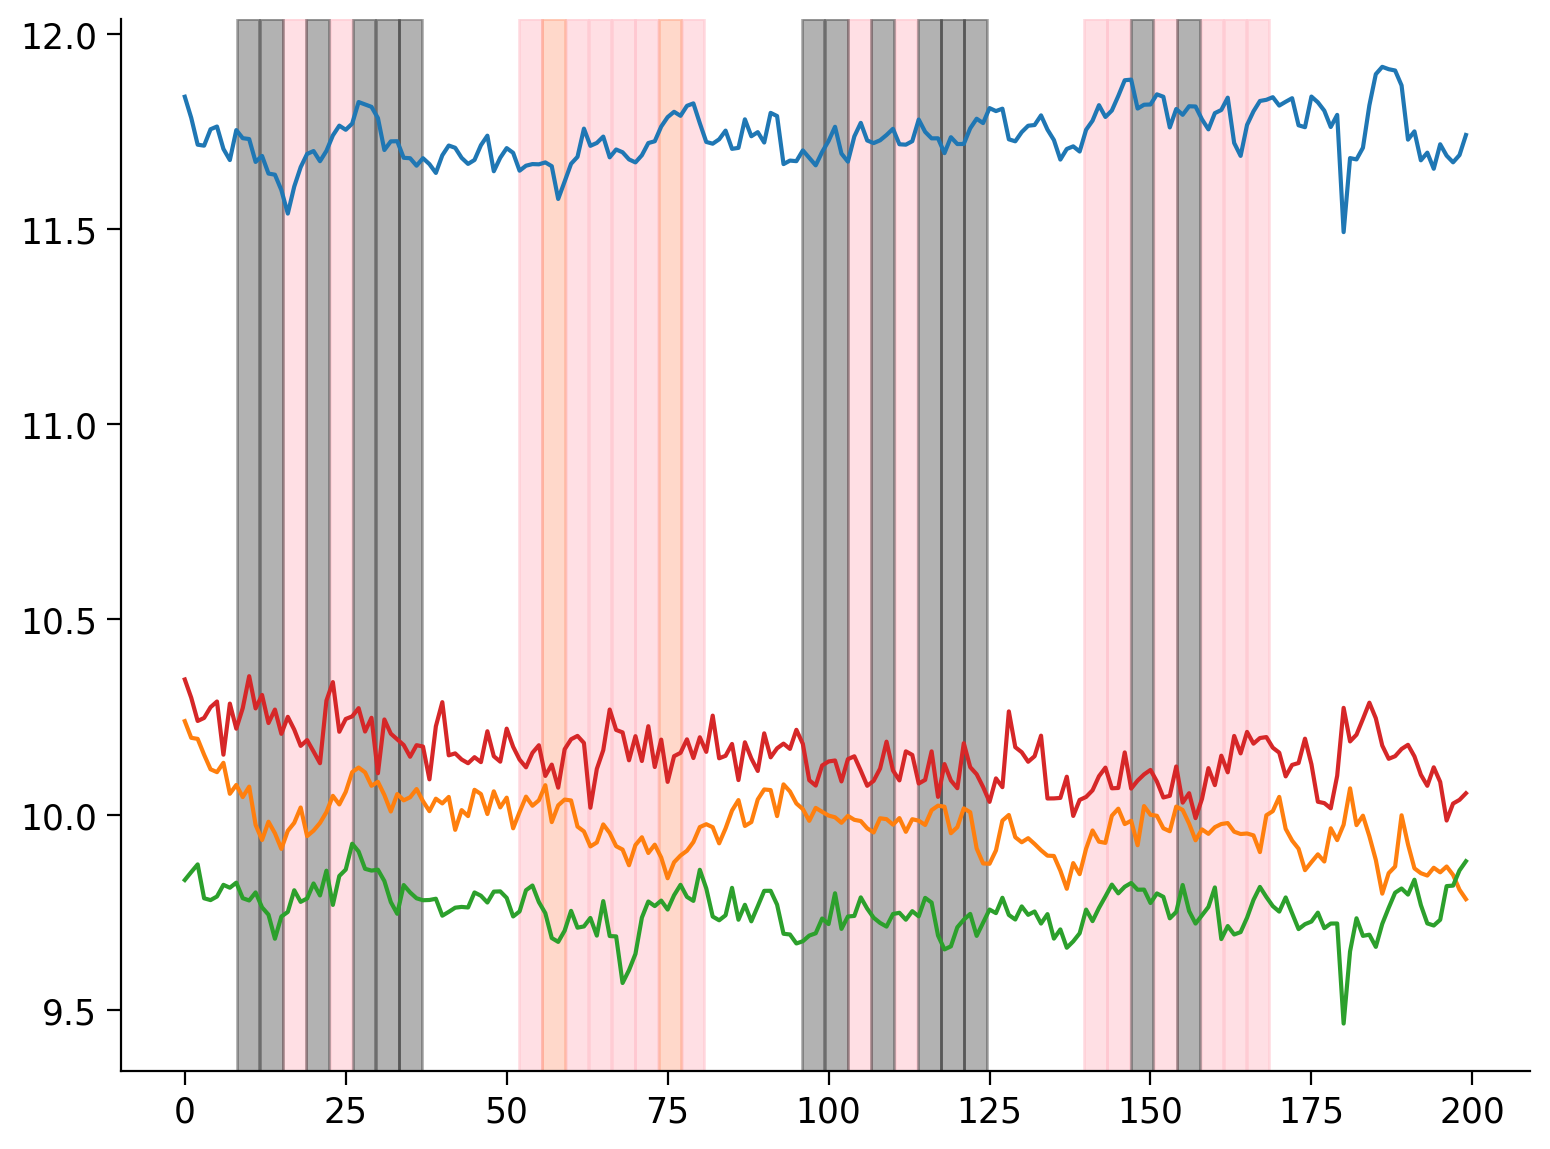

In [121]:
plt.plot(figsize=(20,10))
plt.plot(ts[0][:200]/1000)
plt.plot(ts[10][:200]/1000)
plt.plot(ts[20][:200]/1000)
plt.plot(ts[100][:200]/1000)
for xx in win_ev:
  plt.axvspan(xx, xx+3.5,color='pink',alpha=0.5)

for yy in loss_ev:
  plt.axvspan(yy, yy+3.5,color='black',alpha=0.3)

for aa in neut_ev:
  plt.axvspan(aa, aa+3.5,color='coral',alpha=0.3)

For the motor task, this evs variable contains a list of 5 arrays corresponding to the 5 conditions.

Now let's use these evs to compare the average activity during the left foot ('lf') and right foot ('rf') conditions:

In [17]:
EXPERIMENTS['GAMBLING']['cond'].index('win')

1

In [122]:
# we need a little function that averages all frames from any given condition
def average_frames(data, evs, experiment, cond):
  idx = EXPERIMENTS[experiment]['cond'].index(cond)
  print((len(evs[idx])))
  return np.mean(np.concatenate([np.mean(data[:, evs[idx][i]], axis=1, keepdims=True) for i in range(len(evs[idx]))], axis=-1), axis=1)

# This code needs to be reviewed
#lf_activity = average_frames(data, evs, my_exp, 'lf')
#rf_activity = average_frames(data, evs, my_exp, 'rf')
#contrast = lf_activity - rf_activity  # difference between left and right hand movement

win_avgframes = average_frames(data, evs, my_exp, 'win')
loss_avgframes = average_frames(data, evs, my_exp, 'loss')




2
2


In [123]:
loss_avgframes.shape

(180,)

In [124]:
# Plot activity level in each ROI for both conditions
plt.plot(lf_activity,label='left foot')
plt.plot(rf_activity,label='right foot')
plt.xlabel('ROI')
plt.ylabel('activity')
plt.legend()
plt.show()

NameError: ignored

Now let's plot these activity vectors. We will also make use of the ROI names to find out which brain areas show highest activity in these conditions. But since there are so many areas, we will group them by network.

A powerful tool for organising and plotting this data is the combination of pandas and seaborn. Below is an example where we use pandas to create a table for the activity data and we use seaborn oto visualise it.





In [133]:
region_info['network'][0] == region_info['network'][180]#.shape


True

In [ ]:

    ts = ts_all[int(N_PARCELS/2):]


In [139]:
if my_hemi == 'right':
  df = pd.DataFrame({'win_avgframes' : win_avgframes,
                    'loss_avgframes' : loss_avgframes,
                    'network' : region_info['network'][:int(N_PARCELS/2)],
                    'hemi' : my_hemi})
else:
  df = pd.DataFrame({'win_avgframes' : win_avgframes,
                    'loss_avgframes' : loss_avgframes,
                    'network' : region_info['network'][int(N_PARCELS/2):],
                    'hemi' : my_hemi})


In [140]:
df

,win_avgframes,loss_avgframes,network,hemi
0,-17.240880,21.092810,Visual1,left
1,22.029277,-9.997003,Visual2,left
2,-7.989881,-13.563272,Visual2,left
3,2.434130,-3.205630,Visual2,left
4,9.253911,-14.970970,Visual2,left
...,...,...,...,...
175,-8.533105,-8.773121,Posterior-Mu,left
176,8.851226,-3.184401,Frontopariet,left
177,-10.874668,-7.209675,Cingulo-Oper,left
178,26.090413,10.915919,Cingulo-Oper,left


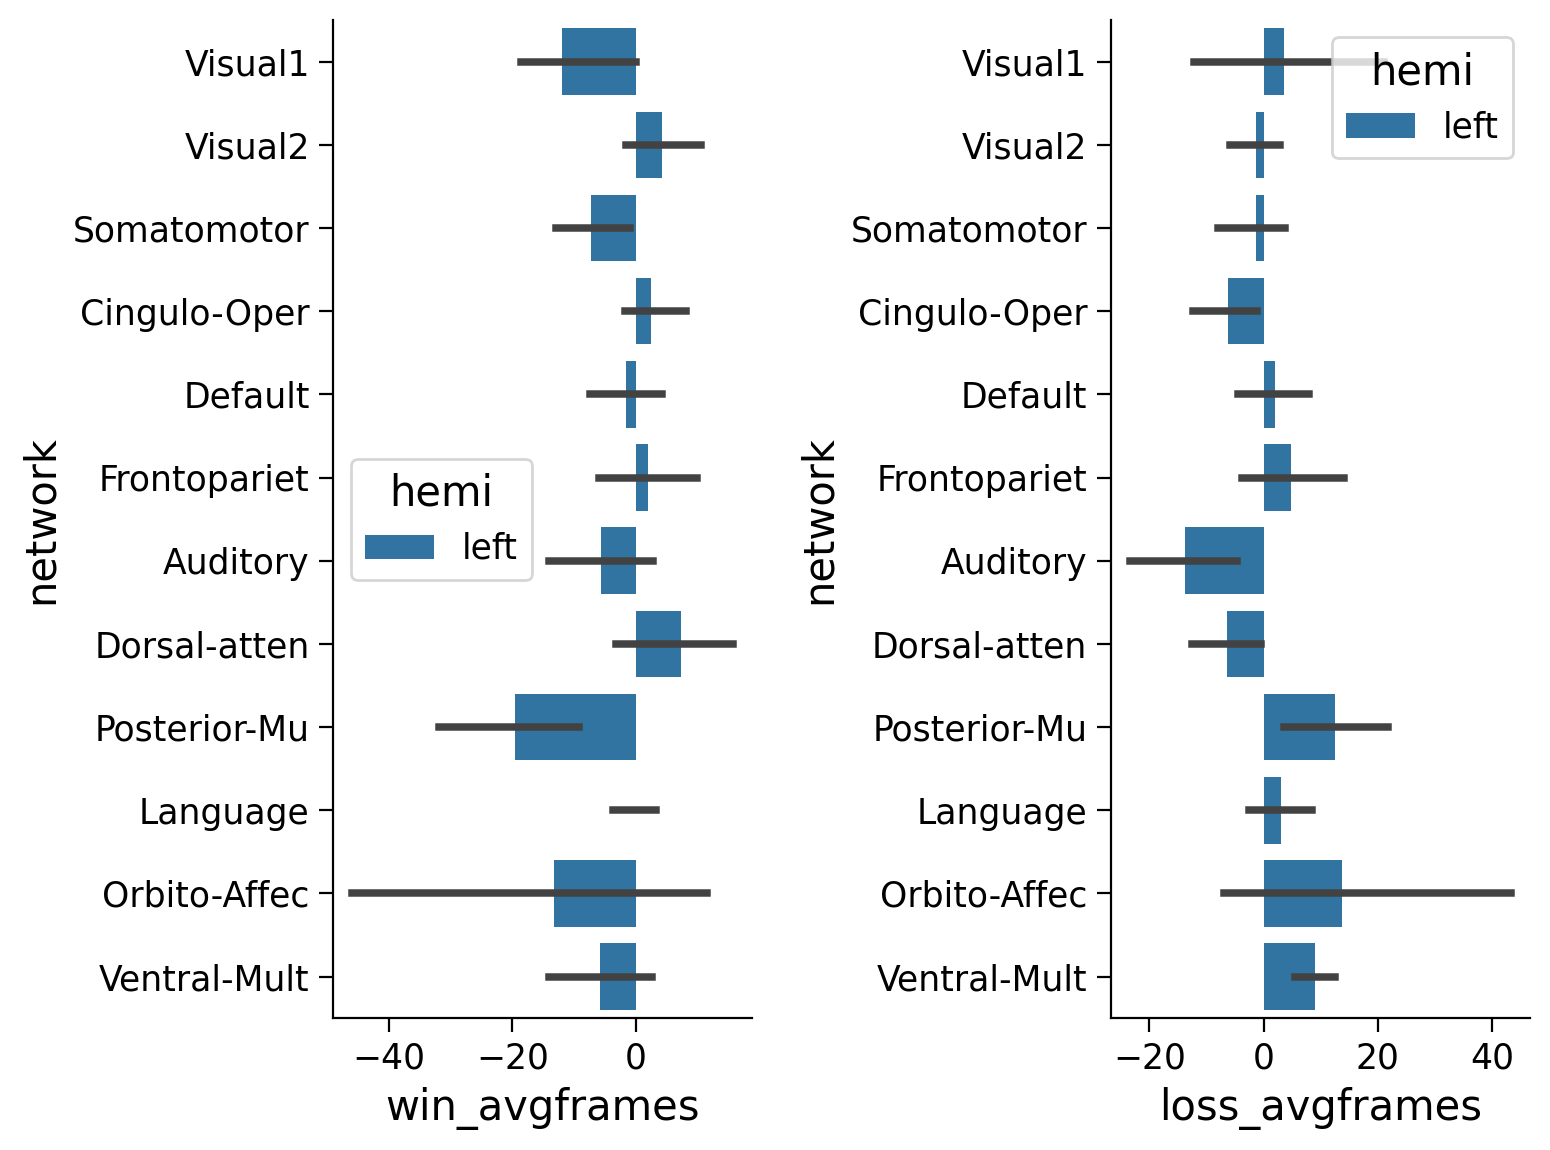

In [141]:

fig, (ax1, ax2) = plt.subplots(1, 2)
sns.barplot(y='network', x='win_avgframes', data=df, hue='hemi',ax=ax1)
sns.barplot(y='network', x='loss_avgframes', data=df, hue='hemi',ax=ax2)
plt.show()

In [98]:
df = pd.DataFrame({'lf_activity' : lf_activity,
                   'rf_activity' : rf_activity,
                   'network' : region_info['network'],
                   'hemi' : region_info['hemi']})

fig, (ax1, ax2) = plt.subplots(1, 2)
sns.barplot(y='network', x='lf_activity', data=df, hue='hemi',ax=ax1)
sns.barplot(y='network', x='rf_activity', data=df, hue='hemi',ax=ax2)
plt.show()

NameError: ignored

You should be able to notice that for the somatosensory network, brain activity in the right hemi is higher for the left foot movement and vice versa for the left hemi and right foot. But this may be subtle at the single subject/session level (these are quick 3-4min scans).


Let us boost thee stats by averaging across all subjects and runs.

In [ ]:
group_contrast = 0
for s in subjects:
  for r in [0, 1]:
    data = load_single_timeseries(subject=s, experiment=my_exp,
                                  run=r, remove_mean=True)
    evs = load_evs(subject=s, experiment=my_exp,run=r)

    lf_activity = average_frames(data, evs, my_exp, 'lf')
    rf_activity = average_frames(data, evs, my_exp, 'rf')

    contrast = lf_activity - rf_activity
    group_contrast += contrast

group_contrast /= (len(subjects)*2)  # remember: 2 sessions per subject

In [135]:
bold_run  = RUNS[my_run]
df = pd.DataFrame({'contrast' : group_contrast,
                   'network' : region_info['network'],
                   'hemi' : region_info['hemi']
                   })
# we will plot the left foot minus right foot contrast so we only need one plot
plt.figure()
sns.barplot(y='network', x='contrast', data=df, hue='hemi')
plt.show()

NameError: ignored

In [136]:
bold_run

'RL'

# Visualising the results on a brain

Finally, we will visualise these resuts on the cortical surface of an average brain.

In [ ]:
# @title NMA provides an atlas. Run this cell to download it
import os, requests

# NMA provides an atlas
fname = f"{HCP_DIR}/atlas.npz"
url = "https://osf.io/j5kuc/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

with np.load(fname) as dobj:
  atlas = dict(**dobj)

In [ ]:
!pip install nilearn

In [ ]:
# This uses the nilearn package
from nilearn import plotting, datasets

# Try both hemispheres (L->R and left->right)
fsaverage = datasets.fetch_surf_fsaverage()
surf_contrast = group_contrast[atlas["labels_L"]]
plotting.view_surf(fsaverage['infl_left'],
                   surf_contrast,
                   vmax=20)

Ian: Work in progress code for computing functional connectivity matrices from timeseries data.

In [142]:
#  compute connectivity matrices function; adpated from https://github.com/xxlya/BrainGNN_Pytorch/blob/main/imports/preprocess_data.py
def subject_connectivity(timeseries, subjects, kind, iter_no='', seed=1234,
                         n_subjects=''):
    """
        timeseries   : timeseries table for subject (timepoints x regions)
        subjects     : subject IDs
        kind         : the kind of connectivity to be used, e.g. lasso, partial correlation, correlation
        iter_no      : tangent connectivity iteration number for cross validation evaluation
    returns:
        connectivity : connectivity matrix (regions x regions)
    """

    if kind in ['TPE', 'TE', 'correlation','partial correlation']:
        if kind not in ['TPE', 'TE']:
            conn_measure = connectome.ConnectivityMeasure(kind=kind)
            connectivity = conn_measure.fit_transform(timeseries)
        else:
            if kind == 'TPE':
                conn_measure = connectome.ConnectivityMeasure(kind='correlation')
                conn_mat = conn_measure.fit_transform(timeseries)
                conn_measure = connectome.ConnectivityMeasure(kind='tangent')
                connectivity_fit = conn_measure.fit(conn_mat)
                connectivity = connectivity_fit.transform(conn_mat)
            else:
                conn_measure = connectome.ConnectivityMeasure(kind='tangent')
                connectivity_fit = conn_measure.fit(timeseries)
                connectivity = connectivity_fit.transform(timeseries)


        if kind not in ['TPE', 'TE']:
            return connectivity
        else:
            return connectivity_fit

In [155]:
# loop through subjects, pull data, reorganize for nilearn format (timepoints x regions)
# documentation for the connectome function: https://nilearn.github.io/dev/modules/generated/nilearn.connectome.ConnectivityMeasure.html
from nilearn import connectome
print(range(N_SUBJECTS))
data_pull = []
# time series data contains two catergories of data: split time series for correlation
data_win = []
data_loss = []

for i in range(N_SUBJECTS):
  subject_pull = subjects[i]
  bold_path = f"{HCP_DIR}/subjects/{subject_pull}/GAMBLING/tfMRI_GAMBLING_LR"
  bold_file = "data.npy"
  # suspect I did some of the transposition a little weird at first; old code is commented
  # out and new code (actually using python transpose) is currently what's visible
  ts = win_avgframes #np.load(f"{bold_path}/{bold_file}") # timeseries data from subject i, shape: (360, 253)
  #print(ts.shape)
  #shape_data = ts.shape
  #data_pull.append(ts.reshape(shape_data[1],shape_data[0]))
  data_pull.append(ts.T) # len = 100


range(0, 100)


In [159]:
len(data_pull)

100

In [157]:
# Compute and save connectivity matrices; throwing some future warnings that I think aren't an issue, but not positive
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

corr = subject_connectivity(timeseries = data_pull, subjects = np.expand_dims(subjects, axis = 1), kind = 'correlation');
part_corr = subject_connectivity(timeseries = data_pull, subjects = np.expand_dims(subjects, axis = 1), kind = 'partial correlation');
ax = sns.heatmap(corr[0,:,:], vmin=0.5, vmax=1);
plt.show()

ValueError: ignored

In [ ]:
(corr).shape

In [ ]:
# heavily adapted code from GNN package: https://github.com/xxlya/BrainGNN_Pytorch/blob/main/imports/read_abide_stats_parall.py
# turns single set of matrices into a data graph using torch_geomtetric
#from torch_geometric.data import Data
from networkx.convert_matrix import from_numpy_array
import networkx as nx
#from torch_geometric.utils import remove_self_loops
#from torch_sparse import coalesce

corr_full = corr[1,:,:]
pcorr = part_corr[1,:,:]
num_nodes = pcorr.shape[0]
G = from_numpy_array(pcorr)
A = nx.to_scipy_sparse_array(G)
adj = A.tocoo()
edge_att = np.zeros(len(adj.row))

for i in range(len(adj.row)):
  edge_att[i] = pcorr[adj.row[i], adj.col[i]]

edge_index = np.stack([adj.row, adj.col])
edge_index, edge_att = remove_self_loops(torch.from_numpy(edge_index), torch.from_numpy(edge_att))
edge_index = edge_index.long()
edge_index, edge_att = coalesce(edge_index, edge_att, num_nodes,
                                    num_nodes)

# don't know the best way to rep the labels, tbd
label = 1

att_torch = torch.from_numpy(corr_full).float()
y_torch = torch.from_numpy(np.array(label)).long()  # classification

test_graph = Data(x=att_torch, edge_index=edge_index.long(), y=y_torch, edge_attr=edge_att)